# Определение легендарного покемона по его характеристикам используя kNN

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

dataframe = pd.read_csv(
    "https://raw.githubusercontent.com/YBI-Foundation/Dataset/refs/heads/main/Pokemon.csv",
)

In [22]:
dataframe.head()

,SN,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Attack,Sp. Defense,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


### Проверка есть ли пропущенные данные
Можно сделать выводы что отсутствие данных в колонке `Type 2` никак не помешает

In [23]:
dataframe.isna().sum()

SN               0
Name             0
Type 1           0
Type 2         386
HP               0
Attack           0
Defense          0
Sp. Attack       0
Sp. Defense      0
Speed            0
Generation       0
Legendary        0
dtype: int64

### **Задача.** Выберите бинарную переменную (или сконструируйте из количественной)

Из данного списка можно назначить переменную `Legendary` - `target`

In [24]:
dataframe.dtypes

SN              int64
Name           object
Type 1         object
Type 2         object
HP              int64
Attack          int64
Defense         int64
Sp. Attack      int64
Sp. Defense     int64
Speed           int64
Generation      int64
Legendary        bool
dtype: object

###  **Задача.** Выберите несколько количественных переменных

Исходя из тепловой карты можно сделать выводы, что некоторая корреляция всех выбранных переменных с переменной `Legendary` **есть**. За исключением переменной `Generation`, ее исключаем из набора `Feature` переменных.

p.s в последствии я понял что:
* полагаться на корреляцию только с target переменной неверно т. к может быть **мультиколлинеарность.**
* Корреляция измеряет только линейную зависимость. А kNN может захватывать нелинейные закономерности, если признаки дают хорошее "разделение" в пространстве

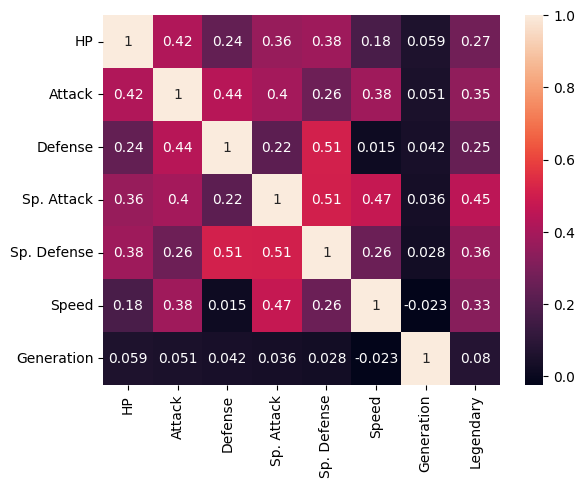

In [50]:
corr = dataframe[["HP", "Attack", "Defense", "Sp. Attack", "Sp. Defense", "Speed", "Generation", "Legendary"]].corr()
clean_corr = corr.drop("Legendary")
sns.heatmap(clean_corr, annot=True)
plt.show()

### **Задача.** Разделите датасет на обучающую и тестовую выборки

In [26]:
from sklearn.model_selection import train_test_split

knn_data = dataframe[["HP", "Attack", "Defense", "Sp. Attack", "Sp. Defense", "Speed", "Legendary"]]
features = knn_data.drop("Legendary", axis=1)
target = knn_data["Legendary"]

Нужно отметить что в данных имеется сильный дисбаланс в классах. Необходимо учитывать это при разделении.

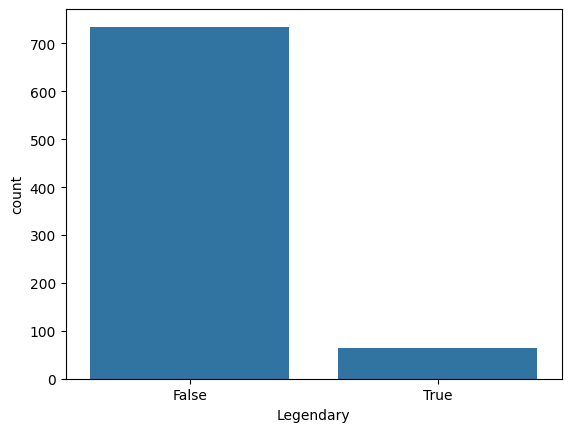

In [27]:
sns.countplot(dataframe, x="Legendary")
plt.show()

In [28]:
train_features, test_features, train_target, test_target = train_test_split(
    features,
    target,
    test_size=0.3,
    random_state=42,
    stratify=target,
)

Проверка что дисбаланс сохранился и в тестовой и в обучающей выборке

In [29]:
train_target.mean()

np.float64(0.08214285714285714)

In [30]:
test_target.mean()

np.float64(0.07916666666666666)

### **Задача.** Проведите стандартизацию объясняющих переменных

In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_features.values)

StandardScaler()

### **Задача.** Обучите алгоритм KNN на обучающей выборке

In [32]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier()
classifier.fit(scaler.transform(train_features.values), train_target)

KNeighborsClassifier()

### **Задача.** Сделайте предсказания целевой переменной для тестовой выборки

In [33]:
test_predict = classifier.predict(scaler.transform(test_features.values))

### **Задача.** Постройте матрицу ошибок

In [34]:
from sklearn.metrics import confusion_matrix

conf_m = confusion_matrix(y_true=test_target, y_pred=test_predict)

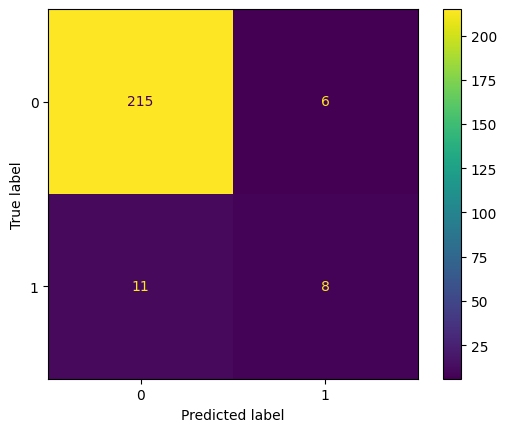

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(conf_m)
disp.plot()
plt.show()

### **Задача.** Рассчитайте метрики качества

In [36]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print(f"accuracy_score: {accuracy_score(y_true=test_target, y_pred=test_predict)}")
print(f"precision_score: {precision_score(y_true=test_target, y_pred=test_predict)}")
print(f"recall_score: {recall_score(y_true=test_target, y_pred=test_predict)}")
print(f"f1_score: {f1_score(y_true=test_target, y_pred=test_predict)}")

accuracy_score: 0.9291666666666667
precision_score: 0.5714285714285714
recall_score: 0.42105263157894735
f1_score: 0.48484848484848486


В сравнении с функцией `classification_report`

In [37]:
from sklearn.metrics import classification_report

print(classification_report(y_true=test_target, y_pred=test_predict))

              precision    recall  f1-score   support

       False       0.95      0.97      0.96       221
        True       0.57      0.42      0.48        19

    accuracy                           0.93       240
   macro avg       0.76      0.70      0.72       240
weighted avg       0.92      0.93      0.92       240



### **Задача.** Подберите гиперпараметр K с наилучшим по вашему мнению качеством

In [78]:
metrics_dep_from_neighbors = pd.DataFrame(columns=["k", "precision_score", "recall_score"])

# Расчет основных метрик для каждой k
for k in range(3, 30):
    classifier = KNeighborsClassifier(k)
    classifier.fit(scaler.transform(train_features.values), train_target)
    test_predict = classifier.predict(scaler.transform(test_features.values))

    metrics_dep_from_neighbors.loc[len(metrics_dep_from_neighbors)] = (
        k,
        precision_score(y_true=test_target, y_pred=test_predict),
        recall_score(y_true=test_target, y_pred=test_predict),
    )

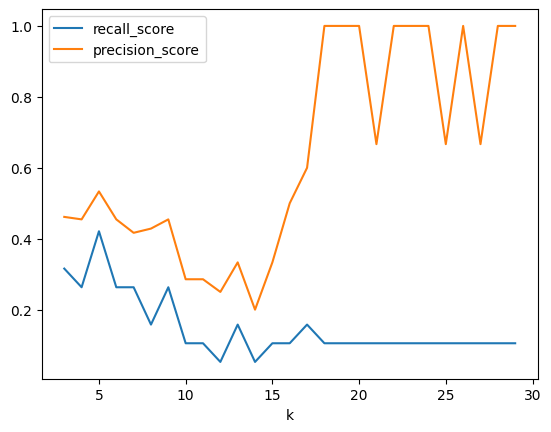

In [79]:
sns.lineplot(metrics_dep_from_neighbors, x="k", y="recall_score", label="recall_score")
sns.lineplot(metrics_dep_from_neighbors, x="k", y="precision_score", label="precision_score")
plt.ylabel("")
plt.show()

In [120]:
metrics_dep_from_neighbors

,k,precision_score,recall_score
0,3.0,0.588235,0.526316
1,4.0,0.600000,0.315789
2,5.0,0.578947,0.578947
3,6.0,0.500000,0.315789
4,7.0,0.571429,0.421053
5,8.0,0.454545,0.263158
6,9.0,0.500000,0.315789
7,10.0,0.833333,0.263158
8,11.0,0.500000,0.315789
9,12.0,0.555556,0.263158


Для задачи классификации покемонов, важнее повысить показатель полноты (recall_score). Т. к лучше ложноположительное срабатывание чем не срабатывание модели на легендарного покемона! Из графика выше, можно отметить, что с увеличением гиперпараметра k - полнота падает.

#### Попытка оптимизации модели

Попытка удалять случайным образом объясняющие переменные привела к удалению переменной HP. Это позволило улучшить показатели как `recall`, так и `precision`.

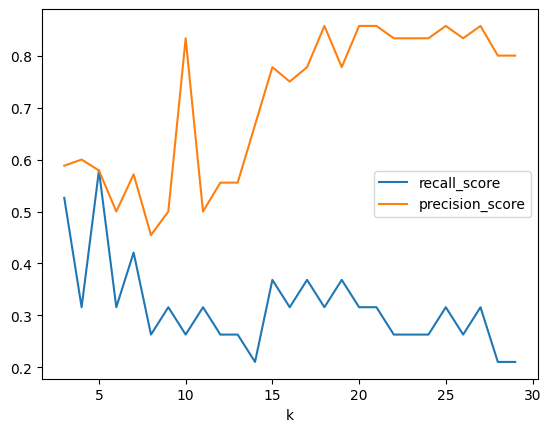

In [118]:
knn_data = dataframe[["Attack", "Defense", "Sp. Attack", "Speed", "Sp. Defense", "Legendary"]]
features = knn_data.drop("Legendary", axis=1)
target = knn_data["Legendary"]

train_features, test_features, train_target, test_target = train_test_split(
    features,
    target,
    test_size=0.3,
    random_state=42,
    stratify=target,
)

scaler = StandardScaler()
scaler.fit(train_features.values)

metrics_dep_from_neighbors = pd.DataFrame(columns=["k", "precision_score", "recall_score"])

# Расчет основных метрик для каждой k
for k in range(3, 30):
    classifier = KNeighborsClassifier(k)
    classifier.fit(scaler.transform(train_features.values), train_target)
    test_predict = classifier.predict(scaler.transform(test_features.values))

    metrics_dep_from_neighbors.loc[len(metrics_dep_from_neighbors)] = (
        k,
        precision_score(y_true=test_target, y_pred=test_predict),
        recall_score(y_true=test_target, y_pred=test_predict),
    )

sns.lineplot(metrics_dep_from_neighbors, x="k", y="recall_score", label="recall_score")
sns.lineplot(metrics_dep_from_neighbors, x="k", y="precision_score", label="precision_score")
plt.ylabel("")
plt.show()

In [119]:
metrics_dep_from_neighbors

,k,precision_score,recall_score
0,3.0,0.588235,0.526316
1,4.0,0.600000,0.315789
2,5.0,0.578947,0.578947
3,6.0,0.500000,0.315789
4,7.0,0.571429,0.421053
5,8.0,0.454545,0.263158
6,9.0,0.500000,0.315789
7,10.0,0.833333,0.263158
8,11.0,0.500000,0.315789
9,12.0,0.555556,0.263158


Исходя из всех данных выше, до попытки оптимизации модели и после, кажется что оптимальное значением k = 5

### **Задача.** Сделайте выводы относительно полученной модели и ее качества

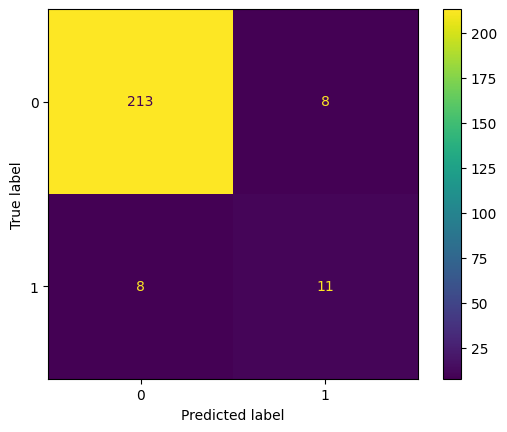

In [121]:
classifier = KNeighborsClassifier(5)
classifier.fit(scaler.transform(train_features.values), train_target)
test_predict = classifier.predict(scaler.transform(test_features.values))
conf_m = confusion_matrix(y_true=test_target, y_pred=test_predict)
disp = ConfusionMatrixDisplay(conf_m)
disp.plot()
plt.show()

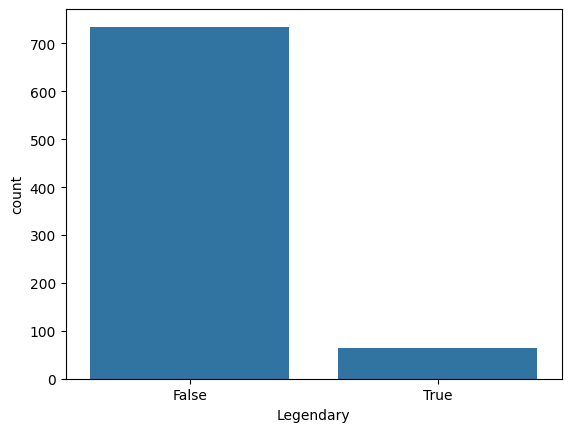

In [124]:
sns.countplot(dataframe, x="Legendary")
plt.show()

In [122]:
print(classification_report(y_true=test_target, y_pred=test_predict))

              precision    recall  f1-score   support

       False       0.96      0.96      0.96       221
        True       0.58      0.58      0.58        19

    accuracy                           0.93       240
   macro avg       0.77      0.77      0.77       240
weighted avg       0.93      0.93      0.93       240



Учитывая огромный дисбаланс в классах, удалось добиться выявления **58% легендарных покемонов** на тестовой выборке. Также из всех положительных предсказаний, количество **ложноположительных составляет всего 42%**. Модель отсеивает до 96% обычных покемонов!